In [1]:
import healpy as hp 
import numpy as np 
import matplotlib.pyplot as plt
import skytools as st 

### Foreground model from Wolz et al. 2024

In [2]:
# Dust model parameters
A_dust_EE = 56 #uK_CMB^2 
A_dust_BB = 28 #uK_CMB^2 
alpha_dust_EE = -0.32 
alpha_dust_BB = -0.16

freq_piv_dust = 353. #GHz
beta_dust = 1.54
T_dust = 20. #K

# Synchrotron model parameters
A_sync_EE = 9. #uK_CMB^2 
A_sync_BB = 1.6 #uK_CMB^2 
alpha_sync_EE = -0.7
alpha_sync_BB = -0.93 

freq_piv_sync = 23. #GHz
beta_sync = -3.


### SO instrument parameters

In [3]:
so_freqs = np.array([27,  39,  93,  145, 225, 280]) #GHz
so_beams = np.array([91., 63., 30., 17., 11., 9. ]) #arcmin (assumed Gaussian)
so_nside = np.array([512, 512, 512, 512, 512, 512])
lmax = 3 * int(so_nside.max()) - 1


### Foreground power spectra at pivot frequences

In [4]:
def dust_cl(lmax):
    ells = np.arange(lmax+1)
    Dell_factor = ells * (ells + 1) / (2 * np.pi)
    
    cl_dust_EE = np.zeros(ells.shape)
    cl_dust_BB = np.zeros(ells.shape)

    cl_dust_EE[2:] = A_dust_EE * (ells[2:] / 80.)**alpha_dust_EE
    cl_dust_BB[2:] = A_dust_BB * (ells[2:] / 80.)**alpha_dust_BB

    cl_dust_EE[2:] /= Dell_factor[2:]
    cl_dust_BB[2:] /= Dell_factor[2:]

    return cl_dust_EE, cl_dust_BB

def sync_cl(lmax):
    ells = np.arange(lmax+1)
    Dell_factor = ells * (ells + 1) / (2 * np.pi)

    cl_sync_EE = np.zeros(ells.shape)
    cl_sync_BB = np.zeros(ells.shape)

    cl_sync_EE[2:] = A_sync_EE * (ells[2:] / 80.)**alpha_sync_EE
    cl_sync_BB[2:] = A_sync_BB * (ells[2:] / 80.)**alpha_sync_BB

    cl_sync_EE[2:] /= Dell_factor[2:]
    cl_sync_BB[2:] /= Dell_factor[2:]

    return cl_sync_EE, cl_sync_BB

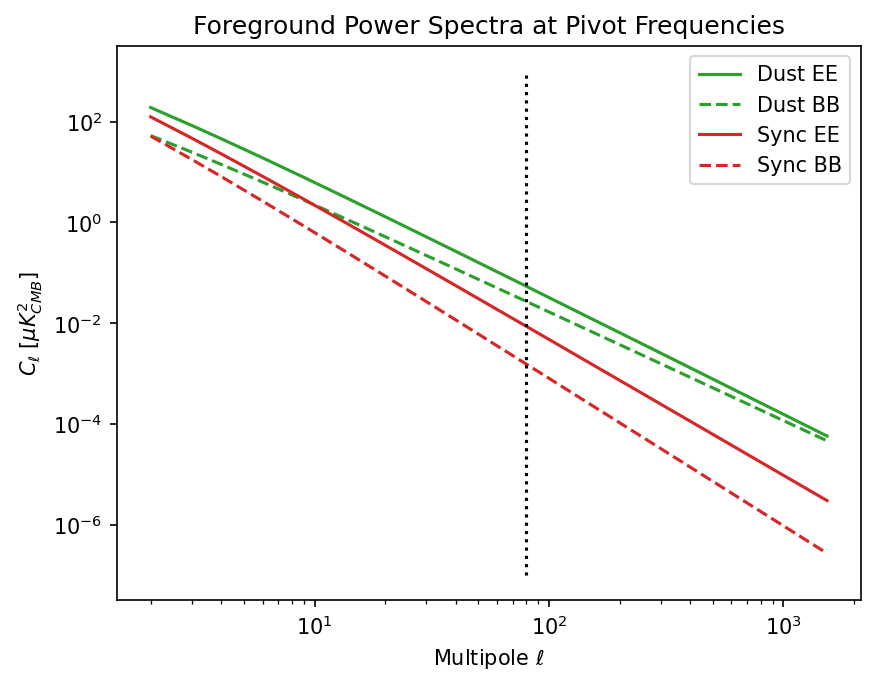

In [7]:
dust_cl_EE, dust_cl_BB = dust_cl(lmax)
sync_cl_EE, sync_cl_BB = sync_cl(lmax)

plt.figure(dpi=150)
ells = np.arange(lmax+1)
plt.plot(ells[2:], dust_cl_EE[2:], ls='-', c='C2', label='Dust EE')
plt.plot(ells[2:], dust_cl_BB[2:], ls='--', c='C2', label='Dust BB')
plt.plot(ells[2:], sync_cl_EE[2:], ls='-', c='C3', label='Sync EE')
plt.plot(ells[2:], sync_cl_BB[2:], ls='--', c='C3', label='Sync BB')
plt.vlines(80, 1e-7, 1e3, colors='k', linestyles='dotted')
plt.loglog()
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [$\mu K_{CMB}^2$]')
plt.legend()
plt.title('Foreground Power Spectra at Pivot Frequencies')
# plt.show()
plt.savefig('./validation/foreground_cl_pivot_freqs.png', dpi=150)

### Foreground frequency scaling

In [8]:
def dust_scaling(freq):
    U = st.KCMB_to_MJysr(freq) * st.MJysr_to_Kb(freq)
    return st.greybody(freq, freq_piv_dust, beta_dust - 2., T_dust) / U         # Following Planck convention (Planck 2018 XI) of beta_dust - 2 for MBB in antenna temperature units

def sync_scaling(freq):
    U = st.KCMB_to_MJysr(freq) * st.MJysr_to_Kb(freq)
    return st.powerlaw(freq, freq_piv_sync, beta_sync) / U

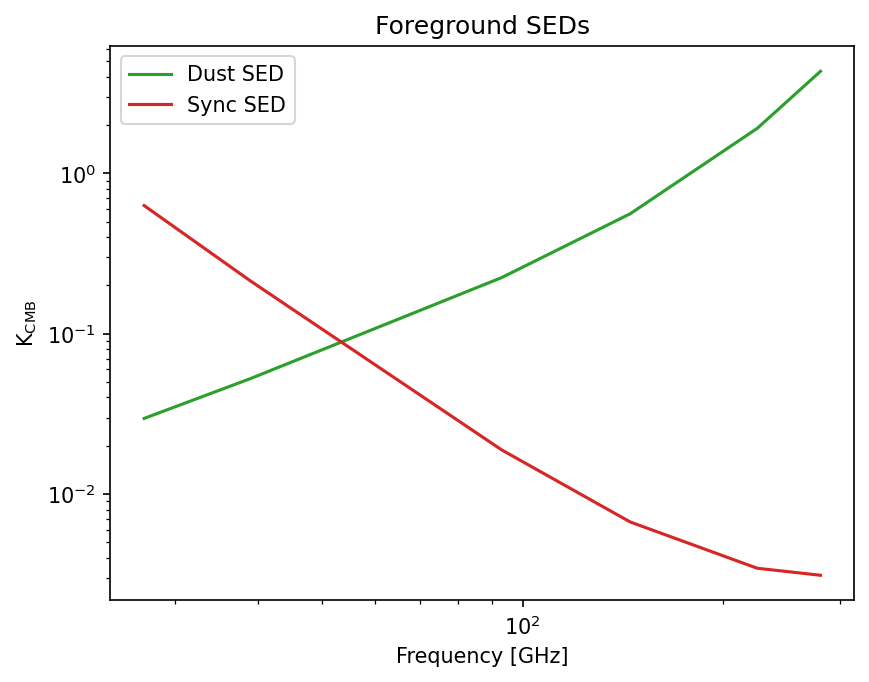

In [9]:
dust_sed = []
sync_sed = []

for freq in so_freqs:
    dust_sed.append(dust_scaling(freq))
    sync_sed.append(sync_scaling(freq))

plt.figure(dpi=150)
plt.plot(so_freqs, np.array(dust_sed), '-', c='C2', label='Dust SED')
plt.plot(so_freqs, np.array(sync_sed), '-', c='C3', label='Sync SED')
plt.loglog()
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'$\rm K_{CMB}$')
plt.legend()
plt.title('Foreground SEDs')
plt.savefig('./validation/foreground_sed.png', dpi=150)

### Functions to generate dust/synchortron alms at pivot

In [10]:
cl_d_EE, cl_d_BB = dust_cl(lmax)
cl_s_EE, cl_s_BB = sync_cl(lmax)

def dust_alms_at_pivot(lmax):
    alms_d_EE = hp.synalm(cl_d_EE, lmax=lmax)
    alms_d_BB = hp.synalm(cl_d_BB, lmax=lmax)
    
    # fl = np.ones(cl_d_EE.shape)
    # fl[0:2] = 0

    # alms_d_EE = hp.almxfl(alms_d_EE, fl)
    # alms_d_BB = hp.almxfl(alms_d_BB, fl)

    return alms_d_EE, alms_d_BB

def sync_alms_at_pivot(lmax):
    alms_s_EE = hp.synalm(cl_s_EE, lmax=lmax)
    alms_s_BB = hp.synalm(cl_s_BB, lmax=lmax)
    
    # fl = np.ones(cl_s_EE.shape)
    # fl[0:2] = 0
    
    # alms_s_EE = hp.almxfl(alms_s_EE, fl)
    # alms_s_BB = hp.almxfl(alms_s_BB, fl)
    
    return alms_s_EE, alms_s_BB

### Function to produce Q/U foreground maps for different channels

In [11]:
alms_d_EE, alms_d_BB = dust_alms_at_pivot(lmax)
alms_s_EE, alms_s_BB = sync_alms_at_pivot(lmax)

def get_fg_map(freq, beam_fwhm, nside):
    dust_scale = dust_scaling(freq)
    sync_scale = sync_scaling(freq)

    alms_fg_EE = dust_scale * alms_d_EE + sync_scale * alms_s_EE
    alms_fg_BB = dust_scale * alms_d_BB + sync_scale * alms_s_BB
    
    bl = hp.gauss_beam(np.deg2rad(beam_fwhm / 60.), lmax=lmax, pol=True)
    alms_fg_EE = hp.almxfl(alms_fg_EE, bl[:,1])
    alms_fg_BB = hp.almxfl(alms_fg_BB, bl[:,2])

    fg_map_Q, fg_map_U = hp.alm2map_spin([alms_fg_EE, alms_fg_BB], nside, 2, lmax=lmax)

    return fg_map_Q, fg_map_U

### Validation

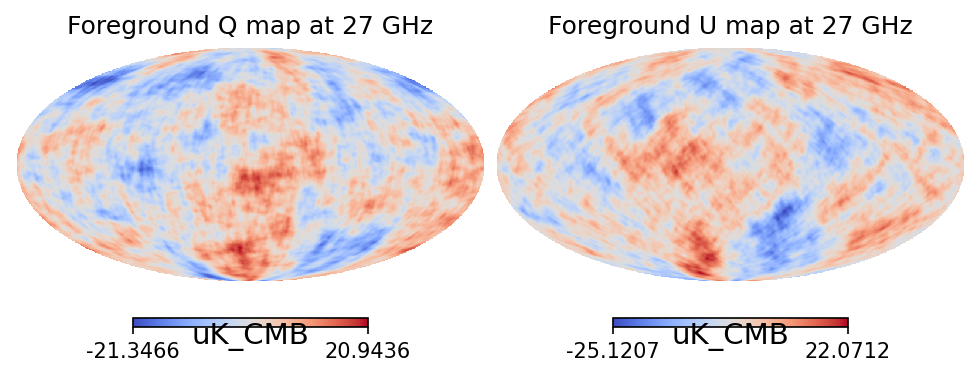

In [17]:
nu = so_freqs[0]
fwhm = so_beams[0]
nside = so_nside[0]

fg_Q, fg_U = get_fg_map(nu, fwhm, nside)

plt.figure(dpi=150)
hp.mollview(fg_Q, title=f'Foreground Q map at {nu} GHz', unit='uK_CMB', sub=121, cmap='coolwarm')
hp.mollview(fg_U, title=f'Foreground U map at {nu} GHz', unit='uK_CMB', sub=122, cmap='coolwarm')
plt.savefig(f'./validation/foreground_maps_{nu}GHz.png', dpi=150, bbox_inches='tight')

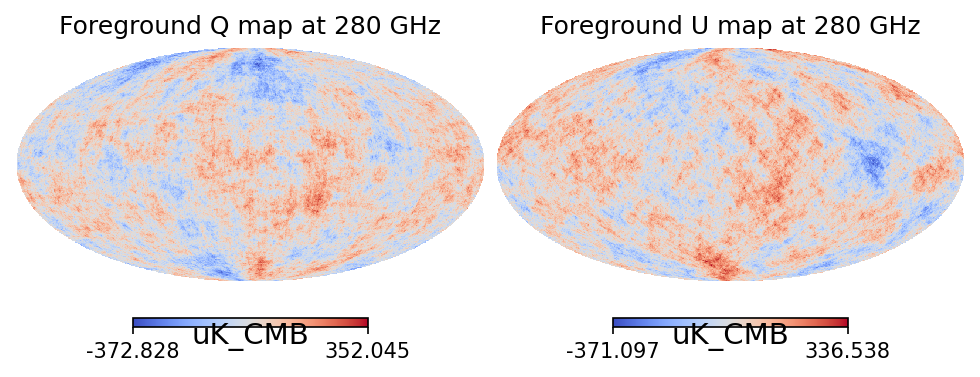

In [15]:
nu = so_freqs[-1]
fwhm = so_beams[-1]
nside = so_nside[-1]

fg_Q, fg_U = get_fg_map(nu, fwhm, nside)
plt.figure(dpi=150)
hp.mollview(fg_Q, title=f'Foreground Q map at {nu} GHz', unit='uK_CMB', sub=121, cmap='coolwarm')
hp.mollview(fg_U, title=f'Foreground U map at {nu} GHz', unit='uK_CMB', sub=122, cmap='coolwarm')
plt.savefig(f'./validation/foreground_maps_{nu}GHz.png', dpi=150, bbox_inches='tight')

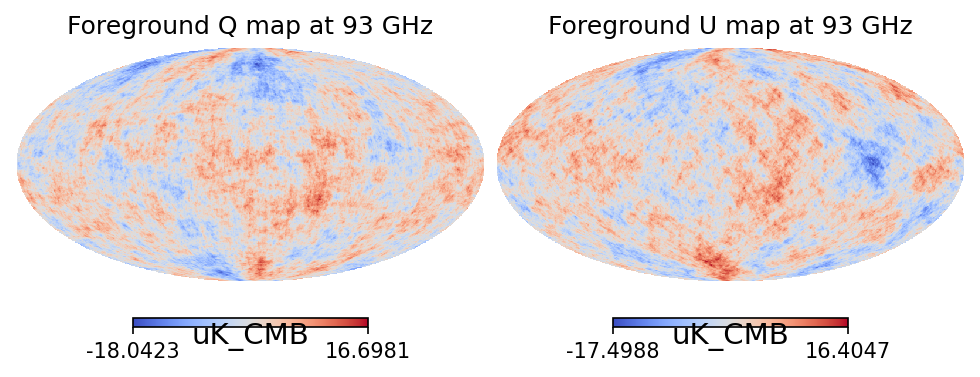

In [16]:
nu = so_freqs[2]
fwhm = so_beams[2]
nside = so_nside[2]

fg_Q, fg_U = get_fg_map(nu, fwhm, nside)

plt.figure(dpi=150)
hp.mollview(fg_Q, title=f'Foreground Q map at {nu} GHz', unit='uK_CMB', sub=121, cmap='coolwarm')
hp.mollview(fg_U, title=f'Foreground U map at {nu} GHz', unit='uK_CMB', sub=122, cmap='coolwarm')
plt.savefig(f'./validation/foreground_maps_{nu}GHz.png', dpi=150, bbox_inches='tight')

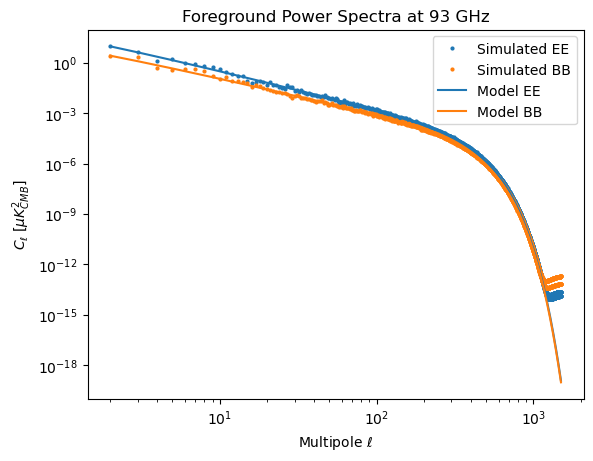

In [44]:
cl_map = hp.anafast([np.zeros(fg_Q.shape), fg_Q, fg_U], lmax=1500, pol=True)
Bl = hp.gauss_beam(np.deg2rad(so_beams[2] / 60.), lmax=1500, pol=True)

cl_model = (dust_scaling(so_freqs[2])**2) * np.array([dust_cl_EE, dust_cl_BB]) + (sync_scaling(so_freqs[2])**2) * np.array([sync_cl_EE, sync_cl_BB])
ells = np.arange(1501)
plt.plot(ells[2:], cl_map[1][2:], 'o', ms=2, label='Simulated EE', c='C0')
plt.plot(ells[2:], cl_map[2][2:], 'o', ms=2, label='Simulated BB', c='C1')
plt.plot(ells[2:1501], cl_model[0][2:1501]*Bl[2:1501,1]**2, ls='-', label='Model EE', c='C0')
plt.plot(ells[2:1501], cl_model[1][2:1501]*Bl[2:1501,2]**2, ls='-', label='Model BB', c='C1')
plt.loglog()
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [$\mu K_{CMB}^2$]')
plt.title(f'Foreground Power Spectra at {so_freqs[2]} GHz')
plt.legend()
plt.show()

### Validate script output

In [7]:
fg_map1 = hp.read_map('../output/foreground_sims/sobs_gaussfg_freq093GHz_mc000_nside0512.fits', field=(0,1,2))
fg_map2 = hp.read_map('../output/foreground_sims/sobs_gaussfg_freq093GHz_mc001_nside0512.fits', field=(0,1,2))

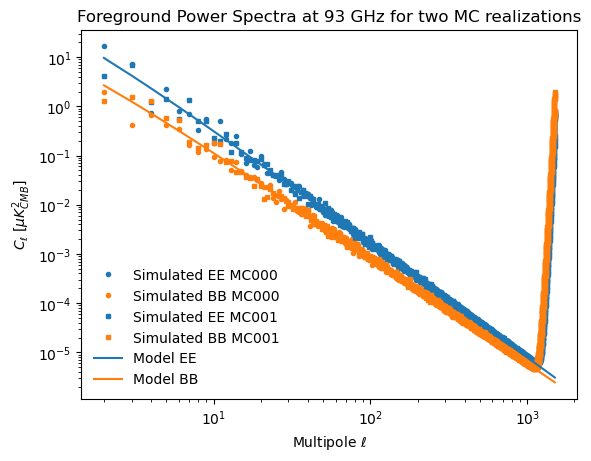

In [10]:
cl_map1 = hp.anafast(fg_map1, lmax=1500, pol=True, use_weights=True, datapath='/pscratch/sd/s/shamikg/skytools_data/')
cl_map2 = hp.anafast(fg_map2, lmax=1500, pol=True, use_weights=True, datapath='/pscratch/sd/s/shamikg/skytools_data/')

Bl = hp.gauss_beam(np.deg2rad(so_beams[2] / 60.), lmax=1500, pol=True)

cl_d_EE, cl_d_BB = dust_cl(1500)
cl_s_EE, cl_s_BB = sync_cl(1500)

ells = np.arange(1501)
plt.plot(ells[2:], cl_map1[1][2:] / Bl[2:,1]**2., 'o', ms=3, label='Simulated EE MC000', c='C0')
plt.plot(ells[2:], cl_map1[2][2:] / Bl[2:,2]**2., 'o', ms=3, label='Simulated BB MC000', c='C1')
plt.plot(ells[2:], cl_map2[1][2:] / Bl[2:,1]**2., 's', ms=3, label='Simulated EE MC001', c='C0')
plt.plot(ells[2:], cl_map2[2][2:] / Bl[2:,2]**2., 's', ms=3, label='Simulated BB MC001', c='C1')
plt.plot(ells[2:1501], (dust_scaling(so_freqs[2])**2) * cl_d_EE[2:1501] + (sync_scaling(so_freqs[2])**2) * cl_s_EE[2:1501], ls='-', label='Model EE', c='C0')
plt.plot(ells[2:1501], (dust_scaling(so_freqs[2])**2) * cl_d_BB[2:1501] + (sync_scaling(so_freqs[2])**2) * cl_s_BB[2:1501], ls='-', label='Model BB', c='C1')
plt.loglog()
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [$\mu K_{CMB}^2$]')
plt.title(f'Foreground Power Spectra at {so_freqs[2]} GHz for two MC realizations')
plt.legend(frameon=False)
plt.show()
